# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
data_dir = 'processed-celeba-small/processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/0.4.0/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor()])
    
    train_data = datasets.ImageFolder(data_dir,transform)
    
    train_loader=DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)
    
    return train_loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size,data_dir=data_dir)


Next, you can view some images! You should see square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

/tmp/ipykernel_3893/1073742529.py:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])


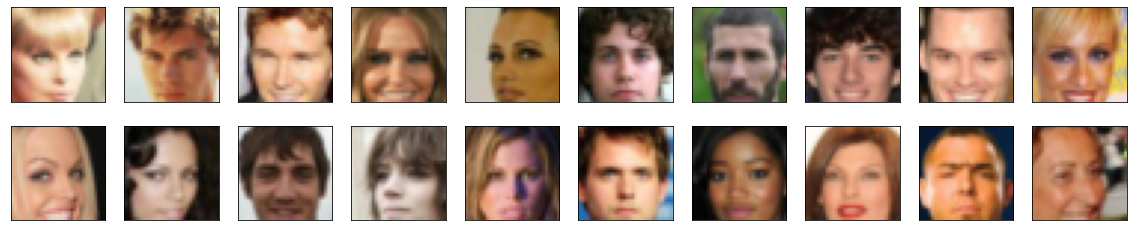

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min,max= feature_range
    x=x* (max-min) +min
    
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.7412)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []


    if batch_norm:
        conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
        layers.append(conv_layer)
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
    else:
        conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=True)
        layers.append(conv_layer)
     
    # using Sequential container
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv(3,conv_dim,4,batch_norm=False)
        self.conv2 = conv(conv_dim,conv_dim*2,4)
        self.conv3 = conv(conv_dim*2,conv_dim*4,4)
        self.conv4 = conv(conv_dim*4,conv_dim*8,4)
        
        self.fc1 = nn.Linear(conv_dim*8*2*2,128)
        self.fc2 = nn.Linear(128,50)
        self.fc3 = nn.Linear(50,1)
        
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x=F.leaky_relu(self.conv1(x),0.2)
        x=F.leaky_relu(self.conv2(x),0.2)
        x=F.leaky_relu(self.conv3(x),0.2)
        x=F.leaky_relu(self.conv4(x),0.2)
        x=x.view(-1,self.conv_dim*8*2*2)
        x=self.fc1(x)
        x=self.dropout(x)
        x=self.fc2(x)
        x=self.dropout(x)
        x=self.fc3(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
def deconv(in_channels,out_channels,kernel_size,stride = 2,padding=1,batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    layers = []
    
    if batch_norm:
        deconv_layer = nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)
        layers.append(deconv_layer)
        layers.append(nn.BatchNorm2d(out_channels))
    else:
        deconv_layer = nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=True)
        layers.append(deconv_layer)
    
    return nn.Sequential(*layers)
    
    

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc1 = nn.Linear(z_size,conv_dim*8*2*2)
        self.deconv1 = deconv(conv_dim*8,conv_dim*4,4)
        self.deconv2 = deconv(conv_dim*4,conv_dim*2,4)
        self.deconv3 = deconv(conv_dim*2,conv_dim,4)
        self.deconv4 = deconv(conv_dim,3,4,batch_norm=False)
        
        self.dropout = nn.Dropout(0.3)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x=self.fc1(x)
        x=self.dropout(x)
        x=x.view(-1,self.conv_dim*8,2,2)
        x=F.relu(self.deconv1(x))
        x=F.relu(self.deconv2(x))
        x=F.relu(self.deconv3(x))
        x=torch.tanh(self.deconv4(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        
        # Apply initial weights to convolutional and linear layers
        init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=10

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [21]:
def real_loss(D_out,smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels=torch.ones(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    if train_on_gpu:
        labels=labels.cuda()
    loss = criterion(D_out.squeeze(),labels)
    return loss
#     return torch.mean((D_out-1)**2)

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels=torch.zeros(batch_size)
    if train_on_gpu:
        labels=labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss
#     return torch.mean(D_out**2)

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

lr=0.0002
beta1=0.5
beta2=0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(),lr,[beta1,beta2])
g_optimizer = optim.Adam(G.parameters(),lr,[beta1,beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [23]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real,smooth=True)
            
            z=np.random.uniform(-1,1,size=(batch_size,z_size))
            z=torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss+d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z=np.random.uniform(-1,1,size=(batch_size,z_size))
            z=torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [24]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.3865 | g_loss: 0.7150
Epoch [    1/   50] | d_loss: 0.3885 | g_loss: 5.0049
Epoch [    1/   50] | d_loss: 0.8742 | g_loss: 6.5323
Epoch [    1/   50] | d_loss: 1.7450 | g_loss: 6.3362
Epoch [    1/   50] | d_loss: 0.5210 | g_loss: 4.0027
Epoch [    1/   50] | d_loss: 0.8392 | g_loss: 2.6541
Epoch [    1/   50] | d_loss: 0.7476 | g_loss: 2.6901
Epoch [    1/   50] | d_loss: 1.3348 | g_loss: 1.0653
Epoch [    1/   50] | d_loss: 0.7601 | g_loss: 3.9768
Epoch [    1/   50] | d_loss: 1.3525 | g_loss: 2.1830
Epoch [    1/   50] | d_loss: 1.6202 | g_loss: 5.9889
Epoch [    1/   50] | d_loss: 1.1618 | g_loss: 1.7378
Epoch [    1/   50] | d_loss: 1.2756 | g_loss: 1.8139
Epoch [    1/   50] | d_loss: 1.1397 | g_loss: 1.6892
Epoch [    1/   50] | d_loss: 0.8503 | g_loss: 2.9140
Epoch [    1/   50] | d_loss: 0.9945 | g_loss: 3.0975
Epoch [    1/   50] | d_loss: 0.9614 | g_loss: 4.6971
Epoch [    1/   50] | d_loss: 0.7589 | g_loss: 4.0219
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.8797 | g_loss: 2.2872
Epoch [    3/   50] | d_loss: 1.4572 | g_loss: 1.4333
Epoch [    3/   50] | d_loss: 0.8221 | g_loss: 3.4355
Epoch [    3/   50] | d_loss: 0.4723 | g_loss: 2.9999
Epoch [    3/   50] | d_loss: 0.5124 | g_loss: 3.3466
Epoch [    3/   50] | d_loss: 0.8053 | g_loss: 4.4977
Epoch [    3/   50] | d_loss: 0.7583 | g_loss: 2.1569
Epoch [    3/   50] | d_loss: 0.7075 | g_loss: 3.4847
Epoch [    3/   50] | d_loss: 0.5886 | g_loss: 2.2016
Epoch [    3/   50] | d_loss: 0.7445 | g_loss: 2.6446
Epoch [    3/   50] | d_loss: 0.7077 | g_loss: 4.4810
Epoch [    3/   50] | d_loss: 0.8088 | g_loss: 2.9550
Epoch [    3/   50] | d_loss: 1.5127 | g_loss: 2.4843
Epoch [    3/   50] | d_loss: 0.8096 | g_loss: 2.6185
Epoch [    3/   50] | d_loss: 0.9572 | g_loss: 2.5738
Epoch [    3/   50] | d_loss: 1.5651 | g_loss: 4.3686
Epoch [    3/   50] | d_loss: 0.7200 | g_loss: 2.7992
Epoch [    3/   50] | d_loss: 0.9678 | g_loss: 3.1099
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.6346 | g_loss: 3.0256
Epoch [    6/   50] | d_loss: 0.6532 | g_loss: 3.5236
Epoch [    6/   50] | d_loss: 0.6150 | g_loss: 3.5856
Epoch [    6/   50] | d_loss: 0.6526 | g_loss: 3.7569
Epoch [    6/   50] | d_loss: 0.5781 | g_loss: 3.1054
Epoch [    6/   50] | d_loss: 0.7316 | g_loss: 3.0072
Epoch [    6/   50] | d_loss: 0.7698 | g_loss: 1.5037
Epoch [    6/   50] | d_loss: 0.7658 | g_loss: 2.0709
Epoch [    6/   50] | d_loss: 0.7558 | g_loss: 3.9720
Epoch [    6/   50] | d_loss: 0.7042 | g_loss: 3.8381
Epoch [    6/   50] | d_loss: 0.4227 | g_loss: 5.7691
Epoch [    6/   50] | d_loss: 0.6314 | g_loss: 3.5931
Epoch [    6/   50] | d_loss: 0.7645 | g_loss: 2.2711
Epoch [    6/   50] | d_loss: 0.6271 | g_loss: 3.5657
Epoch [    6/   50] | d_loss: 1.2981 | g_loss: 4.4525
Epoch [    6/   50] | d_loss: 0.6079 | g_loss: 2.4802
Epoch [    6/   50] | d_loss: 0.4686 | g_loss: 3.5267
Epoch [    6/   50] | d_loss: 0.6698 | g_loss: 2.7783
Epoch [    6/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.5040 | g_loss: 2.7098
Epoch [    9/   50] | d_loss: 0.4397 | g_loss: 3.6905
Epoch [    9/   50] | d_loss: 0.5152 | g_loss: 3.8748
Epoch [    9/   50] | d_loss: 0.8868 | g_loss: 2.4061
Epoch [    9/   50] | d_loss: 0.6922 | g_loss: 1.5318
Epoch [    9/   50] | d_loss: 0.6520 | g_loss: 2.9331
Epoch [    9/   50] | d_loss: 0.9267 | g_loss: 4.0346
Epoch [    9/   50] | d_loss: 0.6532 | g_loss: 2.6201
Epoch [    9/   50] | d_loss: 0.5679 | g_loss: 3.5037
Epoch [    9/   50] | d_loss: 0.6443 | g_loss: 2.4289
Epoch [    9/   50] | d_loss: 0.4623 | g_loss: 5.3722
Epoch [    9/   50] | d_loss: 0.4744 | g_loss: 2.9451
Epoch [    9/   50] | d_loss: 0.5915 | g_loss: 3.7439
Epoch [    9/   50] | d_loss: 0.4265 | g_loss: 4.3591
Epoch [    9/   50] | d_loss: 0.5531 | g_loss: 1.5868
Epoch [    9/   50] | d_loss: 1.0051 | g_loss: 2.2914
Epoch [    9/   50] | d_loss: 0.5204 | g_loss: 2.0001
Epoch [    9/   50] | d_loss: 0.5672 | g_loss: 4.3211
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.5516 | g_loss: 4.3918
Epoch [   11/   50] | d_loss: 0.5553 | g_loss: 2.0683
Epoch [   11/   50] | d_loss: 0.7003 | g_loss: 2.3635
Epoch [   11/   50] | d_loss: 0.4955 | g_loss: 3.6755
Epoch [   11/   50] | d_loss: 0.5163 | g_loss: 3.0536
Epoch [   11/   50] | d_loss: 0.6089 | g_loss: 1.6571
Epoch [   11/   50] | d_loss: 0.7789 | g_loss: 2.9332
Epoch [   11/   50] | d_loss: 0.4649 | g_loss: 3.5356
Epoch [   11/   50] | d_loss: 0.7958 | g_loss: 3.7091
Epoch [   11/   50] | d_loss: 0.5630 | g_loss: 3.8354
Epoch [   11/   50] | d_loss: 0.9537 | g_loss: 5.1571
Epoch [   11/   50] | d_loss: 0.4372 | g_loss: 4.3045
Epoch [   11/   50] | d_loss: 0.5578 | g_loss: 2.3828
Epoch [   11/   50] | d_loss: 0.7532 | g_loss: 2.7379
Epoch [   11/   50] | d_loss: 0.5607 | g_loss: 3.5949
Epoch [   11/   50] | d_loss: 0.4410 | g_loss: 4.4944
Epoch [   11/   50] | d_loss: 0.4745 | g_loss: 4.8993
Epoch [   11/   50] | d_loss: 0.6594 | g_loss: 2.9367
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.5162 | g_loss: 6.2243
Epoch [   14/   50] | d_loss: 0.5050 | g_loss: 3.2083
Epoch [   14/   50] | d_loss: 0.8302 | g_loss: 3.6315
Epoch [   14/   50] | d_loss: 0.4948 | g_loss: 3.1641
Epoch [   14/   50] | d_loss: 0.6848 | g_loss: 2.8481
Epoch [   14/   50] | d_loss: 0.4542 | g_loss: 4.9546
Epoch [   14/   50] | d_loss: 0.7076 | g_loss: 3.7074
Epoch [   14/   50] | d_loss: 0.7190 | g_loss: 3.4909
Epoch [   14/   50] | d_loss: 0.7062 | g_loss: 3.1030
Epoch [   14/   50] | d_loss: 0.4917 | g_loss: 4.6686
Epoch [   14/   50] | d_loss: 0.6244 | g_loss: 2.8070
Epoch [   14/   50] | d_loss: 0.4625 | g_loss: 4.1678
Epoch [   14/   50] | d_loss: 0.5001 | g_loss: 2.5200
Epoch [   14/   50] | d_loss: 0.4281 | g_loss: 5.0969
Epoch [   14/   50] | d_loss: 0.4398 | g_loss: 3.4405
Epoch [   14/   50] | d_loss: 0.4855 | g_loss: 4.2195
Epoch [   14/   50] | d_loss: 0.4830 | g_loss: 3.8537
Epoch [   14/   50] | d_loss: 0.4764 | g_loss: 3.4052
Epoch [   14/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.4577 | g_loss: 3.9125
Epoch [   17/   50] | d_loss: 0.4592 | g_loss: 3.8860
Epoch [   17/   50] | d_loss: 0.4984 | g_loss: 4.1347
Epoch [   17/   50] | d_loss: 0.4177 | g_loss: 5.0942
Epoch [   17/   50] | d_loss: 0.6002 | g_loss: 3.0622
Epoch [   17/   50] | d_loss: 0.5103 | g_loss: 2.2507
Epoch [   17/   50] | d_loss: 0.7150 | g_loss: 4.4126
Epoch [   17/   50] | d_loss: 0.4421 | g_loss: 5.1325
Epoch [   17/   50] | d_loss: 0.4574 | g_loss: 5.9007
Epoch [   17/   50] | d_loss: 0.5018 | g_loss: 3.7407
Epoch [   17/   50] | d_loss: 0.7621 | g_loss: 3.6872
Epoch [   17/   50] | d_loss: 0.5730 | g_loss: 3.4573
Epoch [   17/   50] | d_loss: 0.4647 | g_loss: 3.7129
Epoch [   17/   50] | d_loss: 0.6716 | g_loss: 3.5125
Epoch [   17/   50] | d_loss: 0.5021 | g_loss: 4.2640
Epoch [   17/   50] | d_loss: 0.8177 | g_loss: 1.8784
Epoch [   17/   50] | d_loss: 0.3664 | g_loss: 4.5823
Epoch [   17/   50] | d_loss: 0.5760 | g_loss: 2.7482
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.4373 | g_loss: 5.0571
Epoch [   19/   50] | d_loss: 0.4808 | g_loss: 4.4640
Epoch [   19/   50] | d_loss: 0.4060 | g_loss: 4.9704
Epoch [   19/   50] | d_loss: 0.4261 | g_loss: 4.4090
Epoch [   19/   50] | d_loss: 0.4315 | g_loss: 4.5309
Epoch [   19/   50] | d_loss: 0.7246 | g_loss: 5.1579
Epoch [   19/   50] | d_loss: 0.8947 | g_loss: 1.5341
Epoch [   19/   50] | d_loss: 0.4003 | g_loss: 2.4884
Epoch [   19/   50] | d_loss: 0.7002 | g_loss: 3.0446
Epoch [   19/   50] | d_loss: 0.4579 | g_loss: 2.6996
Epoch [   19/   50] | d_loss: 0.5201 | g_loss: 3.5434
Epoch [   19/   50] | d_loss: 0.4713 | g_loss: 3.7816
Epoch [   19/   50] | d_loss: 0.4308 | g_loss: 4.2740
Epoch [   19/   50] | d_loss: 0.5276 | g_loss: 3.8937
Epoch [   19/   50] | d_loss: 0.5492 | g_loss: 2.9815
Epoch [   19/   50] | d_loss: 0.4619 | g_loss: 2.6563
Epoch [   19/   50] | d_loss: 0.7421 | g_loss: 1.2297
Epoch [   19/   50] | d_loss: 0.4187 | g_loss: 5.1271
Epoch [   19/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.4940 | g_loss: 4.5355
Epoch [   22/   50] | d_loss: 0.5583 | g_loss: 3.1545
Epoch [   22/   50] | d_loss: 0.4861 | g_loss: 3.5476
Epoch [   22/   50] | d_loss: 0.4388 | g_loss: 3.9670
Epoch [   22/   50] | d_loss: 0.3701 | g_loss: 4.9376
Epoch [   22/   50] | d_loss: 0.6538 | g_loss: 6.2361
Epoch [   22/   50] | d_loss: 0.4345 | g_loss: 4.6450
Epoch [   22/   50] | d_loss: 0.4582 | g_loss: 2.8672
Epoch [   22/   50] | d_loss: 0.4616 | g_loss: 4.4388
Epoch [   22/   50] | d_loss: 0.4070 | g_loss: 4.4107
Epoch [   22/   50] | d_loss: 0.5612 | g_loss: 2.9183
Epoch [   22/   50] | d_loss: 0.3724 | g_loss: 5.5459
Epoch [   22/   50] | d_loss: 0.4433 | g_loss: 4.7958
Epoch [   22/   50] | d_loss: 0.4922 | g_loss: 2.7494
Epoch [   22/   50] | d_loss: 0.3941 | g_loss: 2.9664
Epoch [   22/   50] | d_loss: 0.4274 | g_loss: 5.2905
Epoch [   22/   50] | d_loss: 0.4354 | g_loss: 3.4470
Epoch [   22/   50] | d_loss: 0.6057 | g_loss: 4.1336
Epoch [   22/   50] | d_loss

Epoch [   25/   50] | d_loss: 0.3830 | g_loss: 4.4282
Epoch [   25/   50] | d_loss: 0.5222 | g_loss: 3.2000
Epoch [   25/   50] | d_loss: 0.4609 | g_loss: 4.0995
Epoch [   25/   50] | d_loss: 0.5706 | g_loss: 4.4064
Epoch [   25/   50] | d_loss: 0.4146 | g_loss: 3.8854
Epoch [   25/   50] | d_loss: 0.4913 | g_loss: 5.3361
Epoch [   25/   50] | d_loss: 0.9928 | g_loss: 4.0703
Epoch [   25/   50] | d_loss: 0.4024 | g_loss: 5.1088
Epoch [   25/   50] | d_loss: 0.5077 | g_loss: 3.0399
Epoch [   25/   50] | d_loss: 0.4066 | g_loss: 5.1781
Epoch [   25/   50] | d_loss: 0.5386 | g_loss: 4.4346
Epoch [   25/   50] | d_loss: 0.4253 | g_loss: 5.2672
Epoch [   25/   50] | d_loss: 0.4125 | g_loss: 3.9225
Epoch [   25/   50] | d_loss: 0.4390 | g_loss: 3.1277
Epoch [   25/   50] | d_loss: 0.3949 | g_loss: 4.0285
Epoch [   25/   50] | d_loss: 0.4994 | g_loss: 4.1678
Epoch [   25/   50] | d_loss: 0.4045 | g_loss: 3.1907
Epoch [   25/   50] | d_loss: 0.4886 | g_loss: 3.6675
Epoch [   25/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.3806 | g_loss: 5.2913
Epoch [   27/   50] | d_loss: 0.4736 | g_loss: 5.7193
Epoch [   27/   50] | d_loss: 0.6868 | g_loss: 3.8748
Epoch [   27/   50] | d_loss: 0.4775 | g_loss: 4.9435
Epoch [   27/   50] | d_loss: 0.4565 | g_loss: 4.8498
Epoch [   27/   50] | d_loss: 0.5364 | g_loss: 3.1845
Epoch [   27/   50] | d_loss: 0.3782 | g_loss: 4.4144
Epoch [   27/   50] | d_loss: 0.5767 | g_loss: 2.7928
Epoch [   27/   50] | d_loss: 0.4218 | g_loss: 3.0656
Epoch [   27/   50] | d_loss: 0.3669 | g_loss: 4.9548
Epoch [   27/   50] | d_loss: 0.5560 | g_loss: 3.4411
Epoch [   27/   50] | d_loss: 0.6378 | g_loss: 6.2861
Epoch [   27/   50] | d_loss: 0.4315 | g_loss: 2.7596
Epoch [   27/   50] | d_loss: 0.4701 | g_loss: 3.9232
Epoch [   27/   50] | d_loss: 0.3724 | g_loss: 3.3929
Epoch [   27/   50] | d_loss: 0.3951 | g_loss: 3.8925
Epoch [   27/   50] | d_loss: 0.6123 | g_loss: 3.1040
Epoch [   27/   50] | d_loss: 0.4037 | g_loss: 4.9012
Epoch [   27/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.4385 | g_loss: 3.9602
Epoch [   30/   50] | d_loss: 0.4284 | g_loss: 4.6371
Epoch [   30/   50] | d_loss: 0.3967 | g_loss: 3.6358
Epoch [   30/   50] | d_loss: 0.3546 | g_loss: 5.6801
Epoch [   30/   50] | d_loss: 0.3651 | g_loss: 4.5304
Epoch [   30/   50] | d_loss: 0.4326 | g_loss: 5.4953
Epoch [   30/   50] | d_loss: 0.3981 | g_loss: 4.7728
Epoch [   30/   50] | d_loss: 0.3943 | g_loss: 5.0785
Epoch [   30/   50] | d_loss: 0.5014 | g_loss: 3.3645
Epoch [   30/   50] | d_loss: 0.5427 | g_loss: 5.0028
Epoch [   30/   50] | d_loss: 0.3870 | g_loss: 4.0773
Epoch [   30/   50] | d_loss: 0.4370 | g_loss: 4.4035
Epoch [   30/   50] | d_loss: 0.4151 | g_loss: 3.6481
Epoch [   30/   50] | d_loss: 0.4181 | g_loss: 5.6921
Epoch [   30/   50] | d_loss: 0.7446 | g_loss: 6.0631
Epoch [   30/   50] | d_loss: 0.4516 | g_loss: 5.5310
Epoch [   30/   50] | d_loss: 0.4391 | g_loss: 4.7366
Epoch [   30/   50] | d_loss: 0.3762 | g_loss: 5.0952
Epoch [   30/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.5524 | g_loss: 3.0137
Epoch [   33/   50] | d_loss: 0.3951 | g_loss: 3.7329
Epoch [   33/   50] | d_loss: 0.4394 | g_loss: 4.2392
Epoch [   33/   50] | d_loss: 0.4391 | g_loss: 3.6727
Epoch [   33/   50] | d_loss: 0.4120 | g_loss: 4.2606
Epoch [   33/   50] | d_loss: 0.8820 | g_loss: 2.7541
Epoch [   33/   50] | d_loss: 0.3900 | g_loss: 4.2055
Epoch [   33/   50] | d_loss: 0.4165 | g_loss: 3.0913
Epoch [   33/   50] | d_loss: 0.3755 | g_loss: 4.8307
Epoch [   33/   50] | d_loss: 0.4011 | g_loss: 4.8133
Epoch [   33/   50] | d_loss: 0.4198 | g_loss: 4.0424
Epoch [   33/   50] | d_loss: 0.4567 | g_loss: 4.9188
Epoch [   33/   50] | d_loss: 0.4738 | g_loss: 3.2648
Epoch [   33/   50] | d_loss: 0.3530 | g_loss: 6.1178
Epoch [   33/   50] | d_loss: 0.5229 | g_loss: 4.5457
Epoch [   33/   50] | d_loss: 0.3557 | g_loss: 5.3267
Epoch [   33/   50] | d_loss: 0.4015 | g_loss: 4.9344
Epoch [   33/   50] | d_loss: 0.4125 | g_loss: 2.9079
Epoch [   33/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.4046 | g_loss: 4.5298
Epoch [   35/   50] | d_loss: 0.3972 | g_loss: 4.7887
Epoch [   35/   50] | d_loss: 0.4932 | g_loss: 3.7414
Epoch [   35/   50] | d_loss: 0.6362 | g_loss: 2.6025
Epoch [   35/   50] | d_loss: 0.5727 | g_loss: 3.2337
Epoch [   35/   50] | d_loss: 0.4883 | g_loss: 3.3672
Epoch [   35/   50] | d_loss: 0.4959 | g_loss: 5.2224
Epoch [   35/   50] | d_loss: 0.4673 | g_loss: 3.8876
Epoch [   35/   50] | d_loss: 0.5470 | g_loss: 4.0460
Epoch [   35/   50] | d_loss: 0.3671 | g_loss: 6.2775
Epoch [   35/   50] | d_loss: 0.4111 | g_loss: 4.4698
Epoch [   35/   50] | d_loss: 0.3921 | g_loss: 4.8168
Epoch [   35/   50] | d_loss: 0.7917 | g_loss: 5.7010
Epoch [   35/   50] | d_loss: 0.4527 | g_loss: 4.0456
Epoch [   35/   50] | d_loss: 0.4305 | g_loss: 4.5568
Epoch [   35/   50] | d_loss: 0.5901 | g_loss: 2.9209
Epoch [   35/   50] | d_loss: 0.4298 | g_loss: 5.1571
Epoch [   35/   50] | d_loss: 0.4581 | g_loss: 3.8035
Epoch [   35/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.4653 | g_loss: 5.5629
Epoch [   38/   50] | d_loss: 0.5263 | g_loss: 3.7221
Epoch [   38/   50] | d_loss: 0.4764 | g_loss: 3.9753
Epoch [   38/   50] | d_loss: 0.3693 | g_loss: 3.4935
Epoch [   38/   50] | d_loss: 0.4118 | g_loss: 4.1868
Epoch [   38/   50] | d_loss: 0.5671 | g_loss: 5.7699
Epoch [   38/   50] | d_loss: 0.3881 | g_loss: 5.1952
Epoch [   38/   50] | d_loss: 0.3471 | g_loss: 5.6858
Epoch [   38/   50] | d_loss: 0.3908 | g_loss: 3.9364
Epoch [   38/   50] | d_loss: 0.5711 | g_loss: 4.7956
Epoch [   38/   50] | d_loss: 0.3877 | g_loss: 4.8375
Epoch [   38/   50] | d_loss: 0.4087 | g_loss: 6.3375
Epoch [   38/   50] | d_loss: 0.4513 | g_loss: 4.1087
Epoch [   38/   50] | d_loss: 0.3674 | g_loss: 5.7179
Epoch [   38/   50] | d_loss: 0.3881 | g_loss: 5.0997
Epoch [   38/   50] | d_loss: 0.4152 | g_loss: 5.2445
Epoch [   38/   50] | d_loss: 0.4252 | g_loss: 4.7313
Epoch [   38/   50] | d_loss: 0.4645 | g_loss: 4.7395
Epoch [   38/   50] | d_loss

Epoch [   41/   50] | d_loss: 1.4246 | g_loss: 3.9268
Epoch [   41/   50] | d_loss: 0.3696 | g_loss: 5.1735
Epoch [   41/   50] | d_loss: 0.3944 | g_loss: 5.0228
Epoch [   41/   50] | d_loss: 0.4753 | g_loss: 2.8993
Epoch [   41/   50] | d_loss: 0.3886 | g_loss: 6.2885
Epoch [   41/   50] | d_loss: 0.4573 | g_loss: 3.5271
Epoch [   41/   50] | d_loss: 0.3479 | g_loss: 4.4734
Epoch [   41/   50] | d_loss: 0.4035 | g_loss: 3.8626
Epoch [   41/   50] | d_loss: 0.4603 | g_loss: 5.0322
Epoch [   41/   50] | d_loss: 0.3957 | g_loss: 3.8629
Epoch [   41/   50] | d_loss: 0.4306 | g_loss: 3.4459
Epoch [   41/   50] | d_loss: 0.3743 | g_loss: 5.5414
Epoch [   41/   50] | d_loss: 0.3910 | g_loss: 4.4572
Epoch [   41/   50] | d_loss: 0.4331 | g_loss: 3.6467
Epoch [   41/   50] | d_loss: 0.3992 | g_loss: 4.9496
Epoch [   41/   50] | d_loss: 0.4029 | g_loss: 5.0645
Epoch [   41/   50] | d_loss: 0.4127 | g_loss: 4.5260
Epoch [   41/   50] | d_loss: 0.4009 | g_loss: 3.5511
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.3613 | g_loss: 5.4574
Epoch [   43/   50] | d_loss: 0.4448 | g_loss: 4.3951
Epoch [   43/   50] | d_loss: 0.4724 | g_loss: 2.9344
Epoch [   43/   50] | d_loss: 0.3978 | g_loss: 3.9333
Epoch [   43/   50] | d_loss: 0.4224 | g_loss: 4.4213
Epoch [   43/   50] | d_loss: 0.3775 | g_loss: 4.7788
Epoch [   43/   50] | d_loss: 0.4262 | g_loss: 3.6029
Epoch [   43/   50] | d_loss: 0.3654 | g_loss: 4.9495
Epoch [   43/   50] | d_loss: 0.6114 | g_loss: 3.5323
Epoch [   43/   50] | d_loss: 0.3716 | g_loss: 4.3258
Epoch [   43/   50] | d_loss: 0.3778 | g_loss: 5.1289
Epoch [   43/   50] | d_loss: 0.4101 | g_loss: 4.5585
Epoch [   43/   50] | d_loss: 0.4507 | g_loss: 4.6145
Epoch [   43/   50] | d_loss: 0.4067 | g_loss: 3.6249
Epoch [   43/   50] | d_loss: 0.4144 | g_loss: 4.6152
Epoch [   43/   50] | d_loss: 0.4343 | g_loss: 5.0243
Epoch [   43/   50] | d_loss: 0.4222 | g_loss: 5.5442
Epoch [   43/   50] | d_loss: 0.5105 | g_loss: 2.2197
Epoch [   43/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.3972 | g_loss: 4.8162
Epoch [   46/   50] | d_loss: 0.3661 | g_loss: 4.7383
Epoch [   46/   50] | d_loss: 0.3874 | g_loss: 5.8064
Epoch [   46/   50] | d_loss: 0.3537 | g_loss: 5.7732
Epoch [   46/   50] | d_loss: 0.3898 | g_loss: 5.2058
Epoch [   46/   50] | d_loss: 0.5644 | g_loss: 3.3305
Epoch [   46/   50] | d_loss: 0.5539 | g_loss: 4.2815
Epoch [   46/   50] | d_loss: 0.4002 | g_loss: 5.1579
Epoch [   46/   50] | d_loss: 0.5864 | g_loss: 5.3864
Epoch [   46/   50] | d_loss: 0.4273 | g_loss: 3.9049
Epoch [   46/   50] | d_loss: 0.3720 | g_loss: 4.9760
Epoch [   46/   50] | d_loss: 0.5103 | g_loss: 2.6207
Epoch [   46/   50] | d_loss: 0.4080 | g_loss: 3.6609
Epoch [   46/   50] | d_loss: 0.4177 | g_loss: 3.1057
Epoch [   46/   50] | d_loss: 0.4641 | g_loss: 3.9095
Epoch [   46/   50] | d_loss: 0.4116 | g_loss: 4.6562
Epoch [   46/   50] | d_loss: 0.3998 | g_loss: 4.2252
Epoch [   46/   50] | d_loss: 0.3660 | g_loss: 6.3915
Epoch [   46/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.3693 | g_loss: 5.1741
Epoch [   49/   50] | d_loss: 0.3728 | g_loss: 5.5922
Epoch [   49/   50] | d_loss: 0.3990 | g_loss: 4.9798
Epoch [   49/   50] | d_loss: 0.3770 | g_loss: 5.4782
Epoch [   49/   50] | d_loss: 0.3502 | g_loss: 6.1690
Epoch [   49/   50] | d_loss: 0.4353 | g_loss: 3.5506
Epoch [   49/   50] | d_loss: 0.3691 | g_loss: 5.5608
Epoch [   49/   50] | d_loss: 0.3864 | g_loss: 3.9375
Epoch [   49/   50] | d_loss: 0.4736 | g_loss: 2.5156
Epoch [   49/   50] | d_loss: 0.3733 | g_loss: 4.8747
Epoch [   49/   50] | d_loss: 0.3726 | g_loss: 4.6382
Epoch [   49/   50] | d_loss: 0.4645 | g_loss: 2.5812
Epoch [   49/   50] | d_loss: 0.3696 | g_loss: 4.0912
Epoch [   49/   50] | d_loss: 0.7880 | g_loss: 2.1747
Epoch [   49/   50] | d_loss: 0.4636 | g_loss: 4.0576
Epoch [   49/   50] | d_loss: 0.3749 | g_loss: 6.2343
Epoch [   49/   50] | d_loss: 0.5831 | g_loss: 5.2512
Epoch [   49/   50] | d_loss: 0.3705 | g_loss: 3.9360
Epoch [   49/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

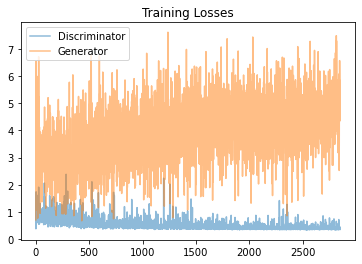

In [25]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [27]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

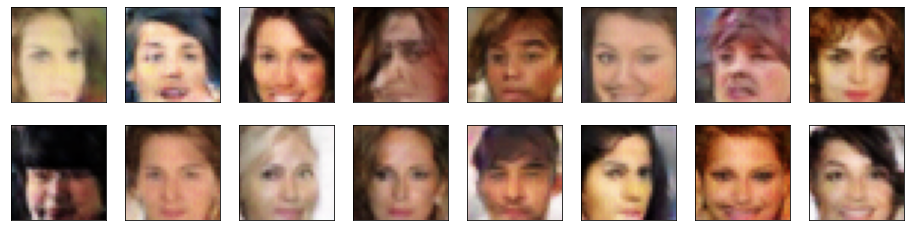

In [28]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
- As can be observed most of the generated images are mostly white, that's due to the fact that the original training dataset is mostly white, and this in-turn dramatically changes the output of our generator.

- The built model has a 4 layer convolutional layer- architecture, which helps capture most feature, but a larger model with more layers and maybe some residual blocks (resnet blocks) might be able to detect more features.

- In this model we used binary cross entropy as a criterion and also we used label smoothing for the discriminator loss to make the training process faster, trying to use MSE instead of BCE might improve the overall performance of the model, and also a slight increase in the number of epochs might give the model a better chance at learning subtle features within the dataset.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.